In [1]:
import pandas as pd                                   # для работы с датафреймом
import numpy as np                                    # для вычислений
import seaborn as sns                                 # для графиков
import matplotlib.pyplot as plt                       # для графиков
from scipy.stats import norm                          # проверка распределения
from scipy import stats                               # статистический анализ
import scipy.stats as stats                           # статистический анализ
from mlxtend.evaluate import permutation_test         # перестановочный тест
import statsmodels.stats.multicomp as mc              # HDS тест для определения групп
import re                                             # для регулярных выражений
from nltk.tokenize import RegexpTokenizer             # библиотека для работы с естественным языком
import nltk                                           # для обработки естественного языка
from nltk import word_tokenize                        # для деления предложений на слова
from nltk.corpus import stopwords                     # для исключения стоп-слов
from wordcloud import WordCloud, STOPWORDS            # для облака слов
from textblob import TextBlob                         # для анализа эмоций


In [2]:
#! pip install mlxtend

In [3]:
#! pip install wordcloud

In [4]:
#! pip install textblob

In [5]:
#! pip install pingouin

In [6]:
import pingouin as pg               # базовые функции библиотеки
from pingouin import welch_anova    # тест Велча

# Загрузка данных и общий обзор #

In [7]:
db = pd.read_csv ('data/books_tidy_data.csv', parse_dates = ['publication_date'], dtype = { 'decade' : 'object', 'quarter' : 'object' , 'tra_co' : 'object' })
# загружаем данные и исправляем тип данных

In [8]:
db.head()

publication_date                                              title  \
0       2006-09-16  Harry Potter and the Half-Blood Prince (Harry ...   
1       2004-09-01  Harry Potter and the Order of the Phoenix (Har...   
2       2003-11-01  Harry Potter and the Chamber of Secrets (Harry...   
3       2004-05-01  Harry Potter and the Prisoner of Azkaban (Harr...   
4       2004-09-13  Harry Potter Boxed Set  Books 1-5 (Harry Potte...   

                      authors  average_rating language_code  num_pages  \
0  J.K. Rowling,Mary GrandPré            4.57           eng        652   
1  J.K. Rowling,Mary GrandPré            4.49           eng        870   
2                J.K. Rowling            4.42           eng        352   
3  J.K. Rowling,Mary GrandPré            4.56           eng        435   
4  J.K. Rowling,Mary GrandPré            4.78           eng       2690   

   ratings_count  text_reviews_count        publisher decade quarter tra_co  
0        2095690               27591  Scholastic Inc.   2000       3      1  
1        2153167               29221  Scholastic Inc.   2000       3      1  
2           6333                 244       Scholastic   2000       4      0  
3        2339585               36325  Scholastic Inc.   2000       2      1  
4          41428                 164       Scholastic   2000       3      1

In [9]:
db = db.set_index ('publication_date') # установка даты в качестве индекса

In [10]:
db.info() # общий обзор данных

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10838 entries, 2006-09-16 to 2006-05-28
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               10838 non-null  object 
 1   authors             10838 non-null  object 
 2   average_rating      10838 non-null  float64
 3   language_code       10838 non-null  object 
 4   num_pages           10838 non-null  int64  
 5   ratings_count       10838 non-null  int64  
 6   text_reviews_count  10838 non-null  int64  
 7   publisher           10838 non-null  object 
 8   decade              10838 non-null  object 
 9   quarter             10838 non-null  object 
 10  tra_co              10838 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 1016.1+ KB


# Цели исследования 
1. характеристики центрального положения для количественных признаков (метод describe)
2. характеристики категориальных данных (метод describe)
3. распределение книг по десятилетиям (график)
4. распределение книг по кварталам (график)
5. книги и авторы с высокими оценками
6. наиболее часто издаваемые книги, авторы (график)
7. влияние соавторов и переводчиков на оценку (дисперсионный анализ)
8. признаки, влияющие на оценку книги (корреляция, дисперсионный анализ)
9. наиболее часто используемые слова в названии книги (NLTK)


# Характеристики центрального положения

In [11]:
pd.set_option('display.float_format', lambda x: '%.3f' % x) # убираем в выводе экспоненту

In [12]:
db.describe()

average_rating  num_pages  ratings_count  text_reviews_count
count       10838.000  10838.000      10838.000           10838.000
mean            3.942    344.175      18347.883             553.075
std             0.295    238.556     113866.010            2599.330
min             1.000     11.000          0.000               0.000
25%             3.770    203.000        117.000              10.000
50%             3.960    304.000        803.500              49.000
75%             4.130    417.000       5226.750             248.000
max             5.000   6576.000    4597666.000           94265.000

In [13]:
av = np.array(db['average_rating'])
stats.trim_mean(av, 0.1) # робастная оценка среднего

3.9531780442804427

In [14]:
db['average_rating'].mad() # медианное абсолютное отклонение

0.224434581719725

Для лучшего понимания признаков следует их описать.
### average_rating
средняя оценка книги, всего значений 10 838, что совпадает для всех признаков, средняя оценка 3.942, стандартное отклонение 0.295.  
Мы дополнительно вычислили робастную оценку среднего 3.953 и медиану для отклонений от среднего 0.224.  
Можно сделать общий вывод, что читатели ставят оценку 3 или 4. Только 25% оценок ниже 3.77
### num_pages
количество страниц в книге, среднее значение 344 страницы. При этом максимальное достигает 6 576 страниц.  
Очевидно, что это выброс (и не один), который нужно будет учитывать при тестировании
### ratings_count
количество оценок, на одну книгу приходится 18 347 отзывов, стандартное отклонение 113 866 (очень много! значит есть книги с аномально большим количеством оценок).  
Но есть книги и с 0 оценок. При этом нижние 25% значений количества оценок меньше 117. Максимальное значение составляет 4 597 666 (почти 5 млн, что это за книга!?)
### text_reviews_count
количество отзывов, в среднем одна книга получает 553 отзыва при среднем отклонении 2 599. Есть книги, у которых отзывы отсутствуют.  
При этом нижние 25% значений количества отзывов составляет 10 отзывов, максимальное значение составляет 94 265.  
Совпадает ли это с максимальным количеством оценок?

In [15]:
db[db['ratings_count'] == 4597666]

title          authors  average_rating  \
publication_date                                                             
2006-09-06        Twilight (Twilight  #1)  Stephenie Meyer           3.590   

                 language_code  num_pages  ratings_count  text_reviews_count  \
publication_date                                                               
2006-09-06                 eng        501        4597666               94265   

                                  publisher decade quarter tra_co  
publication_date                                                   
2006-09-06        Little  Brown and Company   2000       3      0

Данная книга имеет максимальное количество оценок и максимальное количсетво отзывов 

# Характеристики категориальных данных

In [16]:
db[['title', 'authors', 'language_code', 'publisher', 'decade', 'quarter', 'tra_co']].describe() # опишем категориальные признаки

title         authors language_code publisher decade quarter  \
count       10838           10838         10838     10838  10838   10838   
unique      10149            6456            26      2226     13       4   
top     The Iliad  P.G. Wodehouse           eng   Vintage   2000       3   
freq            8              40          8669       318   7332    2851   

       tra_co  
count   10838  
unique      2  
top         0  
freq     6492

10 149 уникальных значений названий из 10 838. Чаще всего встречается The Iliad, 8 раз (если таких книг несколько, то рандомно отображается одна из них).  
Уникальных значений авторов 6 456, наиболее часто встречающееся P.G. Wodehouse (40 раз). 26 различных значений языков, наиболее часто встречающееся eng (8 669 раз).  
Уникальных значений издателей 2 226, наиболее часто встречающееся Vintage (318 раз). Всего значений декад 13, наиболее часто встречающееся 2 000 (7 332 раза).  
Всего значений кварталов 4, наиболее часто встречающееся 3 (2 851 раз). Категорий "с соавтором / переводчиком" всего две (есть / нет). Чаще всего нет, таких случаев 6 492.


# Визуализация данных  
Визуализация используется для того, чтобы "схватить" какие-то гипотезы на имеющихся данных (визуально человеку проще это сделать).  
Однако размещение слишком большого количества данных на графике уменьшает этот эффект простоты. Например, на одном графике можно точками  
отразить распределение по двум признакам, добавить третий признак цветом точек, четвертый - размером точек, пятый - их формой.  
Но такой график будет сложен для чтения, а значит и смысл в визуализации теряется.  

В данном случае мы хотим установить следующее:  
1. распределение целевого признака - средняя оценка  
2. наличие выбросов по количественным признакам  
3. наличие взаимосвязи между признаками  
4. соотношение категориальных данных там, где это уместно 


Text(0.5, 1.0, 'Распределение средних оценок')

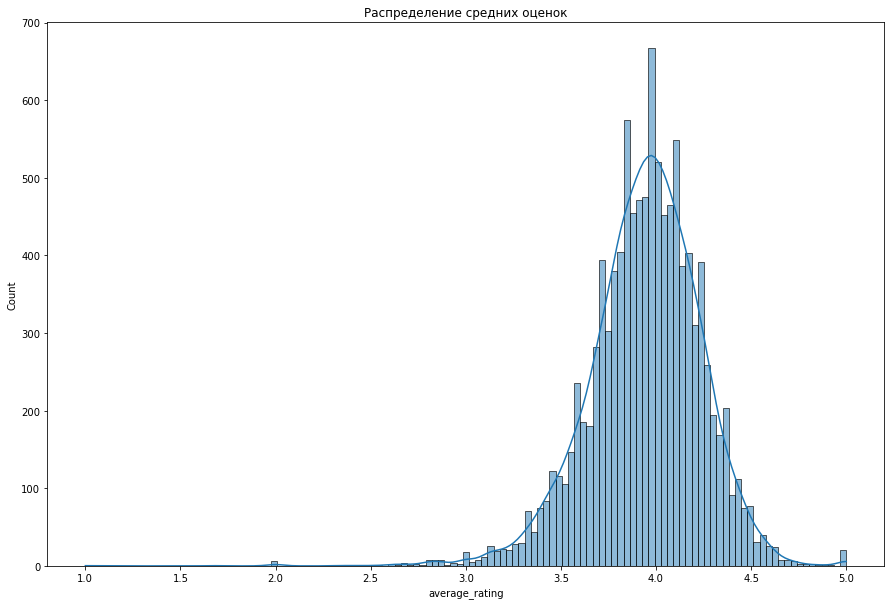

In [17]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.histplot(db['average_rating'], kde = 'True') # линия это плотность распределения, kde ядерная оценка плотности
plt.title('Распределение средних оценок')

Из графика видно, что средние оценки распределены практически нормально. Но в интервалах (2.5 ; 3.0) и (4.8 ; 5.0) имеются небольшие подъемы линии.  
При нормальном распределении этого не должно быть. Это означает, что оценки в указанных интервалах мы наблюдаем чаще, чем это предсказывает нормальное распределение.  
Дополнительная проверка на нормальность распределения с помощью статистических методов будет показана ниже.

#### Анализ выбросов
с помощью boxplots из библиотеки seaborn

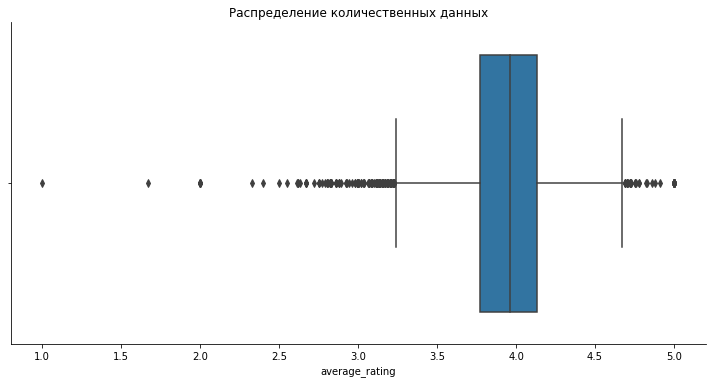

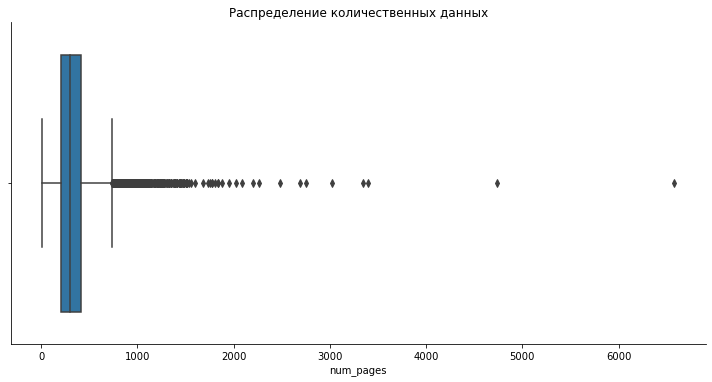

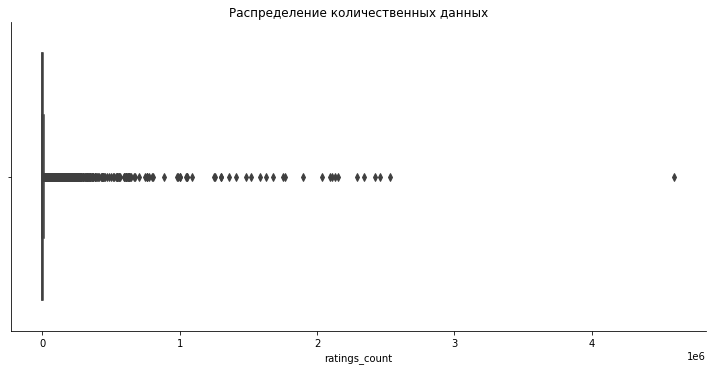

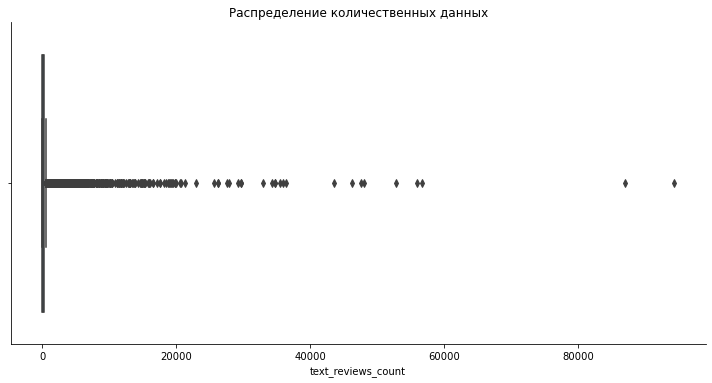

In [18]:
for i in ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count']:
    sns.catplot(kind = 'box', data = db, aspect = 2, x = i)
    plt.title('Распределение количественных данных')

Это ящики с усами (изобретение основателя анализа данных Тьюки). В прямоугольнике посередине показана медиана.  
Левый край прямоугольника - это 25% квартиль, правый край - 75%, усы - межквартильный размах, за пределами усов - выбросы.  
Почему ящик то сжимается, то растягивается? Почему медиана скачет от левой стороны к правой (медиана должна быть посередине???)?  
### Рассмотрим пример

In [19]:
# создадим вектор данных
example = np.array ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) 

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa17fd825e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa17fd82ca0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa17fd82280>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa17fd8c3a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa17fd8c700>],
 'means': []}

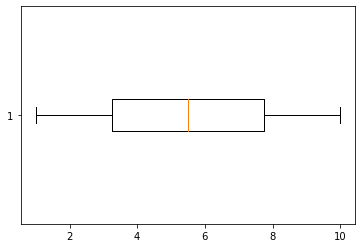

In [20]:
plt.boxplot (example, vert = False)

In [21]:
np.median (example)

5.5

In [22]:
# создадим еще один вектор данных
example_1 = np.array ([1, 2, 3, 4, 5, 6, 51, 53, 54, 100])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa180a1afa0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa180a266a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa180a1ac40>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa180a26d60>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa180a33100>],
 'means': []}

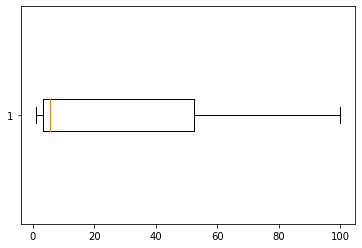

In [23]:
plt.boxplot (example_1, vert = False)

In [24]:
np.median (example_1)

5.5

### Разбор образования усов и написание функций

In [25]:
q1, q3 = np.percentile(example_1, [25, 75]) # считаем квартили

In [26]:
q1 # левый (нижний) квартиль

3.25

In [27]:
q3 # правый (верхний) квартиль

52.5

In [28]:
iqr = q3 - q1 # межквартильный размах
iqr

49.25

In [29]:
lower_bound = q1 - (iqr * 1.5) # левый (нижний) ус
lower_bound

-70.625

In [30]:
upper_bound = q3 + (iqr * 1.5) # правый (верхний) ус
upper_bound

126.375

Имеются два вектора с одинаковым количеством значений и одинаковой медианой, однако, линия медианы на графиках отличается,  
на оси x откладываются значения вектора, на оси y - количество соответствующих значений, количество значений ниже и выше  
медианы не изменилось, но изменился масштаб.

Для построения усов определяем границы усов, далее смотрим, какие из имеющихся значений не выходят за границы усов.  
До минимального (максимального) значения наших усов в установленных границах и строятся усы (поэтому и возникает разница в длине усов).

In [31]:
# Как писать функции? Реализуем функцию, исходя из задачи: приведенный код применить к каждому признаку. Решение: заменить db['average_rating'] на переменную

q1, q3 = np.percentile(db['average_rating'], [25, 75]) # считаем квартили
iqr = q3 - q1                                          # межквартильный размах
lower_bound = q1 - (iqr * 1.5)                         # левый (нижний) ус
upper_bound = q3 + (iqr * 1.5)                         # правый (верхний) ус

In [32]:
lower_bound # нижняя граница выбросов

3.2300000000000004

In [33]:
upper_bound # верхняя граница выбросов

4.67

In [34]:
def outliers (x):
    q1, q3 = np.percentile(x, [25, 75]) # x это переменная
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return lower_bound, upper_bound     # результат, который возвращает функция

In [35]:
# генератор - цикл, который пишется в одну строку
data = [{'Нижний выброс': outliers(i)[0], 'Верхний выброс': outliers(i)[1]} for i in [db['average_rating'], db['num_pages'], db['ratings_count'], db['text_reviews_count']] ]

In [36]:
pd.DataFrame (data, index = ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count'])

Нижний выброс  Верхний выброс
average_rating              3.230           4.670
num_pages                -118.000         738.000
ratings_count           -7547.625       12891.375
text_reviews_count       -347.000         605.000

In [37]:
# Построим график парных распределений для количественных признаков для выявления взаимосвязей
# может долго вычисляться
# sns.pairplot(db)

Имеется линейная связь между количеством отзывов и количеством оценок (это достаточно очевидно).  
Наша цель - определить, от чего зависит средняя оценка книги.  
Построим несколько дополнительных графиков для анализа распределения данных по категориям.

# Распределение книг по десятилетиям

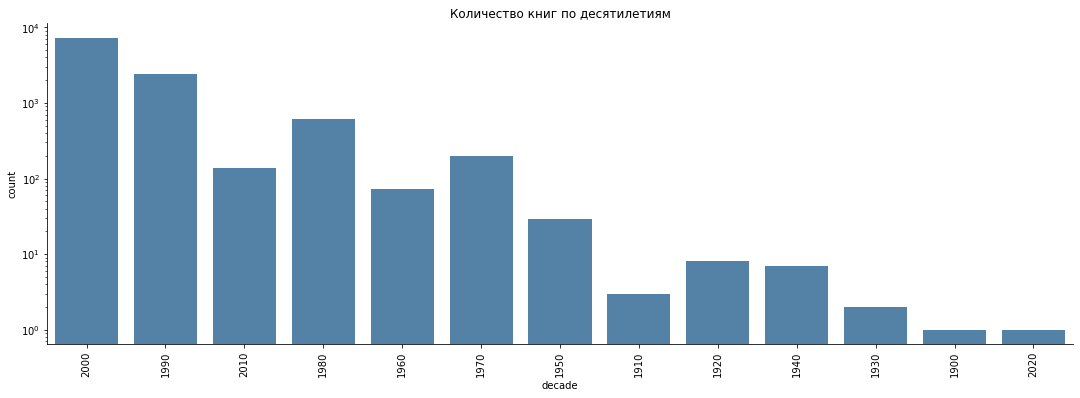

In [38]:
sns.catplot(x = 'decade', data = db, color = 'steelblue', aspect = 3, kind = 'count')
plt.xticks (rotation = 90)  # поворачиваем подписи по оси x
plt.yscale ('log')          # используем логарифмическую шкалу
plt.title ('Количество книг по десятилетиям')
plt.show()

Мало старых книг (1910-1930) и новых (2020). Последнее объясняется датой создания базы, первое можно объяснить тем, что не все книги,  
изданные в те годы, попали в базу, да и самих книг, вероятно, было меньше.
# Распределение книг по кварталам

Text(0.5, 1.0, 'Распределение книг по кварталам')

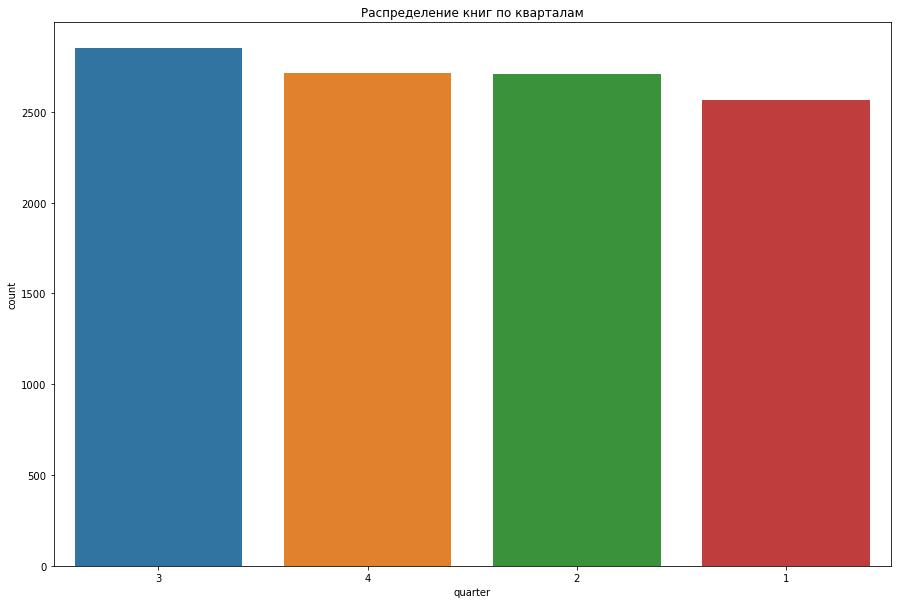

In [39]:
fig, ax = plt.subplots (figsize = (15,10))
sns.countplot(x = db['quarter'])
plt.title('Распределение книг по кварталам')

По кварталам книги распределены приблизительно одинаково
# Распределение книг по языкам

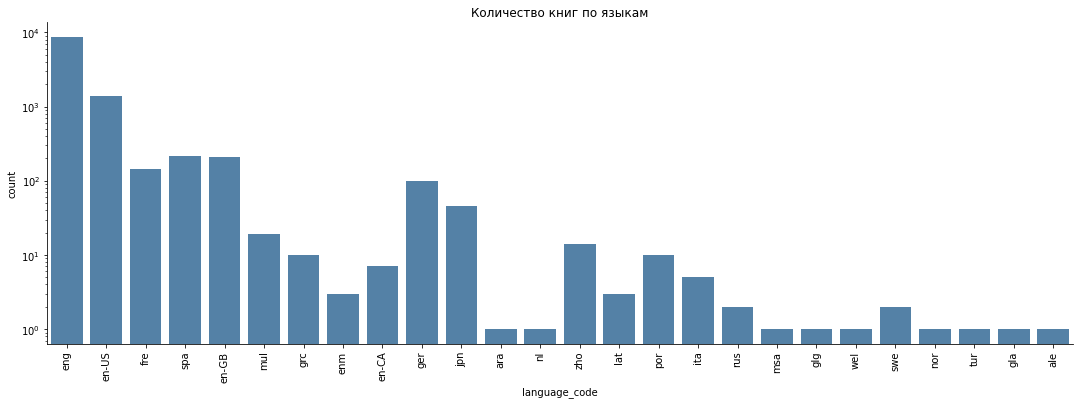

In [40]:
sns.catplot(x = 'language_code', data = db, color = 'steelblue', aspect = 3, kind = 'count')
plt.xticks (rotation = 90)  # поворачиваем подписи по оси x
plt.yscale ('log')          # используем логарифмическую шкалу
plt.title ('Количество книг по языкам')
plt.show()

Английский язык лидер.  
По тем же категориям построим график, который покажет связь со средними оценками.

Text(0.5, 1.0, 'Средние оценки по декадам')

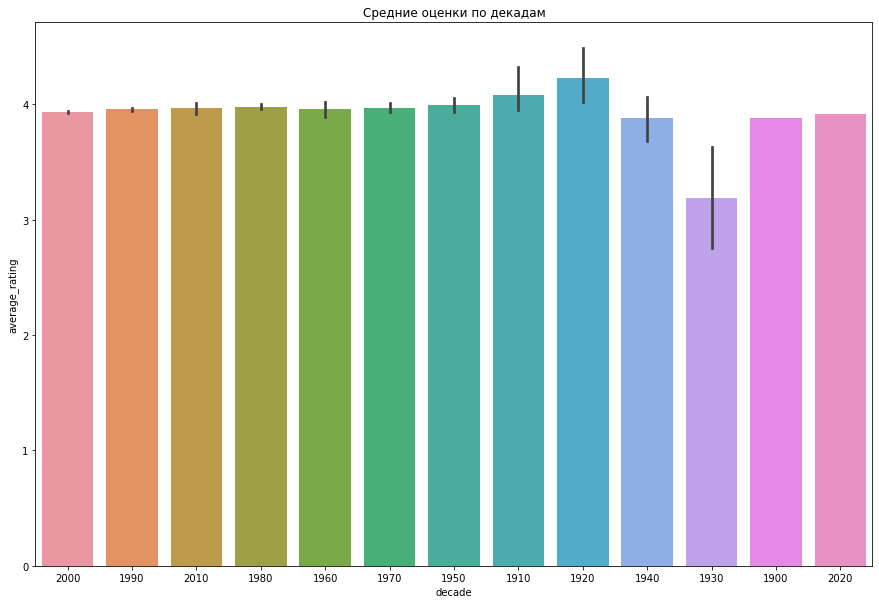

In [41]:
fig, ax = plt.subplots (figsize = (15,10))
sns.barplot(x = db['decade'], y  = db['average_rating']) # распределение средних оценок по декаде издания книги со стандартными отклонениями
plt.title('Средние оценки по декадам')

Оценки примерно одинаково располагаются по декадам. Выбиваются, особенно с учетом стандартного отклонения, 1910 и 1920 годы.  
Почему книги 30-х годов имеют низкую оценку?

In [42]:
db[(db['decade'] == '1910') | (db['decade'] == '1920')] # смотрим, какие книги получили высокую оценку в 1910-1920 гг

title  \
publication_date                                                      
1919-01-01                History of the Peloponnesian War: Bk. 1-2   
1921-01-01                History of the Peloponnesian War: Bk. 5-6   
1923-01-01                History of the Peloponnesian War  Bk. 7-8   
1929-01-01                          The Art of Love and Other Poems   
1922-02-22        Comoediae 1: Acharenses/Equites/Nubes/Vespae/P...   
1925-09-01                                         The Great Gatsby   
1913-01-01                                  On Duties (De Officiis)   
1928-01-01        Discourses  Books 3-4. The Enchiridion (Loeb C...   
1914-01-01                Agricola / Germania / Dialogue on Oratory   
1925-01-01        Scripta Minora: Hiero/Agesilaus/Constitution o...   
1921-01-01                               The Library 1  Books 1-3.9   

                                                            authors  \
publication_date                                                      
1919-01-01                                    Thucydides,C.F. Smith   
1921-01-01                                    Thucydides,C.F. Smith   
1923-01-01                                    Thucydides,C.F. Smith   
1929-01-01                              Ovid,J.H. Mozley,G.P. Goold   
1922-02-22                      Aristophanes,F.W. Hall,W.M. Geldart   
1925-09-01                                      F. Scott Fitzgerald   
1913-01-01                      Marcus Tullius Cicero,Walter Miller   
1928-01-01                           Epictetus,William A. Oldfather   
1914-01-01        Tacitus,Maurice Hutton,Robert Maxwell Ogilvie,...   
1925-01-01                Xenophon,Edgar C. Marchant,G.W. Bowersock   
1921-01-01                          Apollodorus,James George Frazer   

                  average_rating language_code  num_pages  ratings_count  \
publication_date                                                           
1919-01-01                 4.320           mul        496            208   
1921-01-01                 4.350           mul        400             38   
1923-01-01                 4.290           eng        480             35   
1929-01-01                 4.020           eng        400             98   
1922-02-22                 5.000           grc        364              0   
1925-09-01                 3.910           eng        182            149   
1913-01-01                 3.960           eng        448            111   
1928-01-01                 4.340           eng        576            110   
1914-01-01                 3.950           mul        384             87   
1925-01-01                 4.000         en-US        576             19   
1921-01-01                 3.930           mul        464             21   

                  text_reviews_count  \
publication_date                       
1919-01-01                         7   
1921-01-01                         0   
1923-01-01                         0   
1929-01-01                         5   
1922-02-22                         0   
1925-09-01                         7   
1913-01-01                        11   
1928-01-01                         7   
1914-01-01                         7   
1925-01-01                         2   
1921-01-01                         2   

                                                          publisher decade  \
publication_date                                                             
1919-01-01                                 Harvard University Press   1910   
1921-01-01                                 Harvard University Press   1920   
1923-01-01                                 Harvard University Press   1920   
1929-01-01                                 Harvard University Press   1920   
1922-02-22                             Oxford University Press  USA   1920   
1925-09-01                                              Amereon Ltd   1920   
1913-01-01                                 Harvard University Press   1910   
19

In [43]:
db[db['decade'] == '1930']

title  \
publication_date                                            
1935-01-01                           Murder from the East   
1931-12-01        Raised on Rock: Growing Up at Graceland   

                                  authors  average_rating language_code  \
publication_date                                                          
1935-01-01              Carroll John Daly           3.630           eng   
1931-12-01        David Stanley,Mark Bego           2.750           eng   

                  num_pages  ratings_count  text_reviews_count  \
publication_date                                                 
1935-01-01              312             15                   4   
1931-12-01              192              4                   0   

                                    publisher decade quarter tra_co  
publication_date                                                     
1935-01-01           International Polygonics   1930       1      0  
1931-12-01        Trafalgar Square Publishing   1930       4      1

Можно сделать вывод, что книги 1910-1920 это классическая литература, которая была переиздана в тот период.  
Книги 1930 это всего две книги, что несущественно.

Text(0.5, 1.0, 'Средние оценки по кварталам')

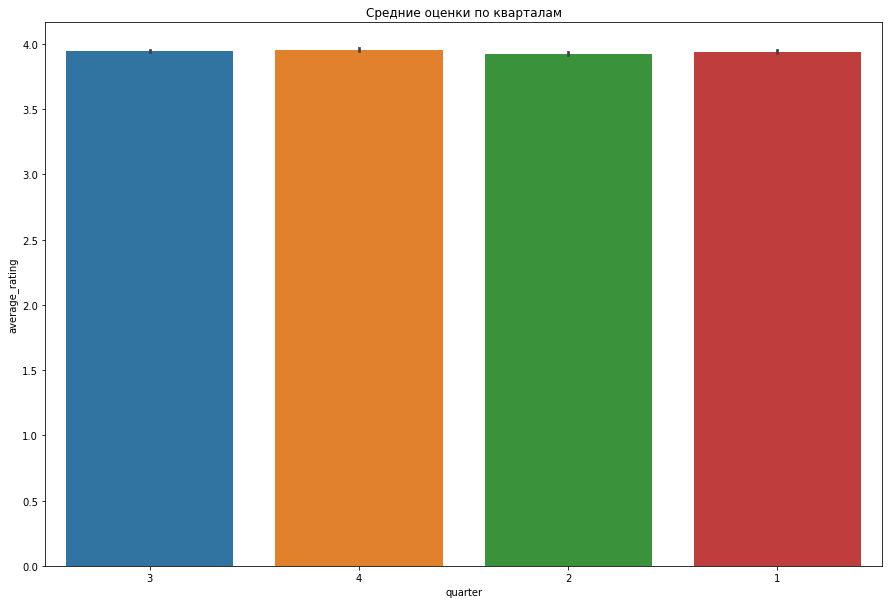

In [44]:
fig, ax = plt.subplots (figsize = (15,10))
sns.barplot(x = db['quarter'], y  = db['average_rating']) # распределение средних оценок по кварталу издания книги со стандартными отклонениями
plt.title('Средние оценки по кварталам')

Получаем примерно одинаковое количество.

Text(0.5, 1.0, 'Средние оценки по языкам')

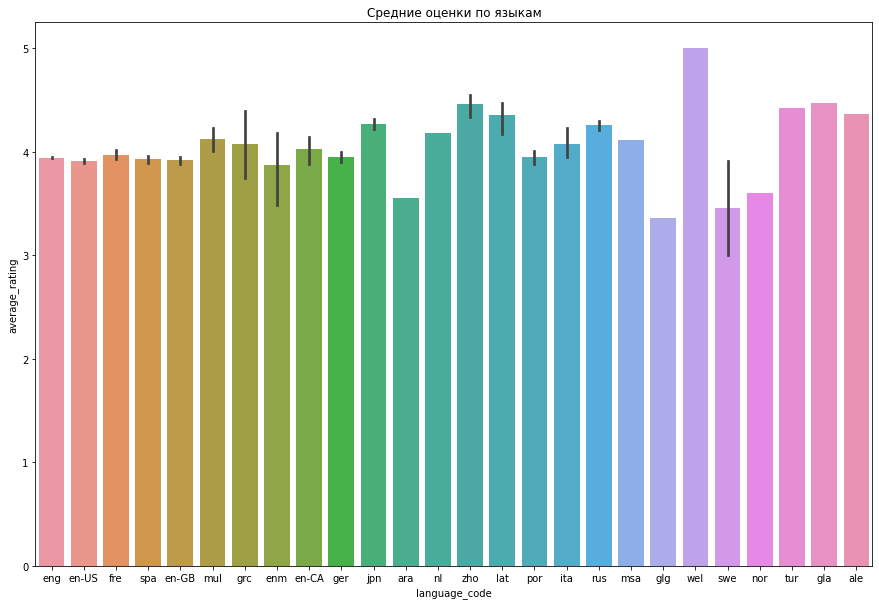

In [45]:
fig, ax = plt.subplots (figsize = (15,10))
sns.barplot(x = db['language_code'], y  = db['average_rating']) # распределение средних оценок по языкам издания книги со стандартными отклонениями
plt.title('Средние оценки по языкам')

# Агрегирование данных
Используем визуализацию для упрощения понимания данных. Аналогично, можно использовать агрегирование данных.  
В тех случаях, где визуализация лишена смысла (слишком много категорий и т.п.), агрегирование может оказаться полезным.

In [46]:
# самые частые книги
db['title'].value_counts()[0:5]

The Iliad                     8
The Odyssey                   8
Anna Karenina                 8
The Brothers Karamazov        7
The Picture of Dorian Gray    7
Name: title, dtype: int64

In [47]:
# самые частые авторы
db['authors'].value_counts()[0:5]

P.G. Wodehouse      40
Rumiko Takahashi    39
Stephen King        38
Orson Scott Card    35
Agatha Christie     32
Name: authors, dtype: int64

In [48]:
# кто получает самые высокие оценки
db.groupby('authors')['average_rating'].mean().sort_values(ascending = False)[0:10]

authors
Sara Barton-Wood                  5.000
John  Diamond                     5.000
Sheri Rose Shepherd               5.000
Ian        Martin,Katie Elliott   5.000
Keith Donohue                     5.000
Nicholas    Evans,Rhonda  Evans   5.000
James E. Campbell                 5.000
Elena N. Mahlow                   5.000
Julie Sylvester,David Sylvester   5.000
Dennis Adler,R.L. Wilson          5.000
Name: average_rating, dtype: float64

In [49]:
# чьи книги получают больше отзывов
db.groupby('authors')['text_reviews_count'].mean().sort_values(ascending = False)[0:10]

authors
Stephenie Meyer                            94265.000
Markus Zusak,Cao Xuân Việt Khương          86881.000
Paulo Coelho,Alan R. Clarke,Özdemir İnce   55843.000
Sara Gruen                                 52759.000
Jeannette Walls                            46176.000
George Orwell,Boris Grabnar,Peter Škerl    29677.000
Charlotte Brontë,Michael Mason             27884.000
J.K. Rowling,Mary GrandPré                 21334.333
Max Brooks                                 20582.000
Diane Setterfield                          18865.000
Name: text_reviews_count, dtype: float64

In [50]:
# книги с самым высоким рейтингом
db.groupby('title')['average_rating'].mean().sort_values(ascending = False)[0:10]

title
The New Big Book of America                                                                         5.000
Bulgakov's the Master and Margarita: The Text as a Cipher                                           5.000
The Complete Theory Fun Factory: Music Theory Puzzles and Games for the Early Grades                5.000
Zone of the Enders: The 2nd Runner Official Strategy Guide                                          5.000
The Irish Anatomist: A Study of Flann O'Brien                                                       5.000
Comoediae 1: Acharenses/Equites/Nubes/Vespae/Pax/Aves                                               5.000
Colossians and Philemon: A Critical and Exegetical Commentary (International Critical Commentary)   5.000
His Princess Devotional: A Royal Encounter With Your King                                           5.000
Taxation of Mineral Rents                                                                           5.000
Tyrannosaurus Wrecks (Stanley  #1)      

In [51]:
# книги с наибольшим количеством отзывов
db.groupby('title')['text_reviews_count'].mean().sort_values(ascending = False)[0:10]

title
Twilight (Twilight  #1)               94265.000
The Book Thief                        86881.000
The Giver (The Giver  #1)             56604.000
Water for Elephants                   52759.000
Eat  Pray  Love                       47620.000
The Glass Castle                      46176.000
The Catcher in the Rye                43499.000
Outlander (Outlander  #1)             34690.000
The Road                              34301.000
The Hobbit  or There and Back Again   32871.000
Name: text_reviews_count, dtype: float64

# Статистический анализ
Рекомендации по книгам:  
1. С. Бослаф Статистика для всех  
2. П. Брюс Практическая статистика для специалистов Data Science (на языке R, отличное изложение статистического анализа)  

Статистический анализ в первом приближении предполагает следующее. У нас есть количественные и категориальные признаки.  
Мы хотим понять, насколько они связаны. Для этого мы рассчитываем специальные статистики на этих данных (например, корреляцию, t-статистику и т.п.).  
Далее 1) либо с помощью специальных таблиц вычисляется p-value, 2) либо получаем точное значение с помощью программных средств.  
P-value используется для определения значимости полученной статистики.  

Для понимания p-value понадобится определение нулевой и альтернативной гипотез. Рассмотрим пример.  
Для статистки t-критерий нулевая гпотеза - это равенство средних значений двух выборок. Альтернативная гпотеза - средние двух выборок не равны.  
P-value это вероятность получить равенство средних значений на тех выборках, что у нас есть. Если такая вероятность меньше заданного уровня (как правило 0.05),  
то мы отвергаем нулевую гипотезу. Другими словами если p-value < 0.05, то вероятность получить равенство двух средних значений очень низкая.  
Поэтому мы отбрасываем нулевую гипотезу и принимаем альтернативную.

Тесты могут быть параметрическими (основываются на известных свойствах распределений) и непараметрическими (не учитывают свойства распределений).  

Также все тесты можно разделить на: применимые только к количественным признакам, применимые только к категориальным признакам,  
применимые как к количественным признакам, так и к категориальным признакам.  

Еще одно деление: одни тесты говорят нам только о наличиии (отсутствии) связи между признаками, другие тесты также показывают силу этой связи.  

Применение любого теста предполагает: 1) определение статистики; 2) проверку на условия применения (нормальность распределения и т.п.);  
3) знание критерия значимости (если p-value опуститься ниже этого критерия, то нулевая гипотеза отвергается);  
4) расчет статистики; 5) проверка значимости по p-value; 6) вывод (отбрасываем нулевую гипотезу или оставляем).

# Корреляция количественных признаков
Стандартный тест для количественных признаков - это тест корреляции Пирсона. Однако предварительно нужно проверить условия для этого теста.  
Если условия соблюдаются, то тест применяется. Если условия не соблюдаются, то можно либо подогнать данные к нормальному распределению  
либо использовать непараметрические тесты.  

Условия такие: 1) независимость выборок, 2) нормальное распределение. Независимость выборок понятие оценочное, поэтому определяется исследователем.  
Нормальное распределение можно проверить специальными методами (визуально, расчетами).

/Users/Shared/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


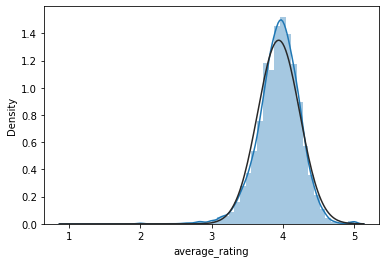

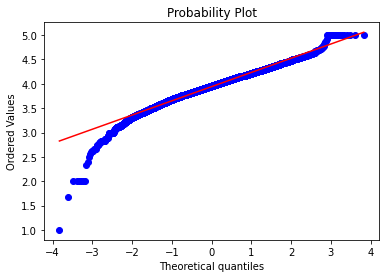

In [52]:
# визуальное определение нормальности распределения
sns.distplot( db['average_rating'], fit = norm)
fig = plt.figure ()
res = stats.probplot( db['average_rating'], plot = plt)

Видим, что распределение оценок близко к нормальному распределению.

In [53]:
# далее используем статистические тесты на нормальность распределения
# тест на нормальность Шапиро
stats.shapiro( db['average_rating'])

/Users/Shared/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9734746217727661, pvalue=1.3771961307384302e-40)

Мы вычислили интересующую нас статистику (Шапиро), далее проверяем нулевую гипотезу (например, в данном случае нулевая гипотеза: данные распределены нормально).  
Так как p-value < 0.05, то мы отвергаем нулевую гиоптезу и принимаем альтернативную (т.е. принимаем, что данные не распределены нормально).  
Такой результат называется статистически значимым. Возможно применение и других методов: тест на нормальность D'Agostino-Pearson, тест Колмогорова-Смирнова.  

Итак, данные не распределены нормально. В этом случае мы можем использовать непараметрические тесты, например, корреляцию Спирмена или перестановочный тест.

Далее будет использоваться библиотека pinqouin, она основана на Statmodels, которая считается стандартом, но при этом предоставляет более удобный вывод результатов,  
а также дополнительные тесты.

In [54]:
# корреляция один против всех по Спирмену
pg.pairwise_corr( db, columns=[['average_rating'],['num_pages', 'ratings_count', 'text_reviews_count']], method='spearman', padjust='bonf')

X                   Y    method       tail      n     r  \
0  average_rating           num_pages  spearman  two-sided  10838 0.119   
1  average_rating       ratings_count  spearman  two-sided  10838 0.086   
2  average_rating  text_reviews_count  spearman  two-sided  10838 0.030   

          CI95%    r2  adj_r2     z  p-unc  p-corr p-adjust  power  
0   [0.1, 0.14] 0.014   0.014 0.119  0.000   0.000     bonf  1.000  
1   [0.07, 0.1] 0.007   0.007 0.087  0.000   0.000     bonf  1.000  
2  [0.01, 0.05] 0.001   0.001 0.030  0.002   0.005     bonf  0.887

Мы построили таблицу корреляции "один против всех", когда одни признак average_rating проверяется на корреляцию со всеми остальными.  
Расшифровка показателей таблицы:

- n это количество наблюдений (строк), которые учитывались при построении корреляции;
- r это коэффициент корреляции по Спирмену (объяснение в книге С.Бослаф Статистика для всех), корреляция слабая.  
Возможно только, что количество страниц связано положительной корреляцией, т.е. уменьшение количества страниц ведет к уменьшению оценки, увеличение - к увеличению.  
- CI95% это доверительный интервал для r;
- r2, adj_r2 это коэффициент детерминации, то есть какая доля дисперсии average_rating может быть объяснена другим признаком;
- z это стандартизированная оценка корреляции;
- p-unc это нескорректированная оценка p-value;
- p-adjust это поправка, которую применили к p-value;
- power это мощность, то есть 1 минус вероятность допустить ошибку 2 типа (нулевая гипотеза на самом деле ложна, но мы не смогли ее отвергнуть).  
Другими словами вероятность обнаружения существующей закономерности.

Вывод  

Средняя оценка не имеет значимых связей с другими количественными данными.  
Отсутствие сильной корреляции пригодится при машинном обучении.
Мы установили, что от количества страниц оценка книги не зависит.

<AxesSubplot:>

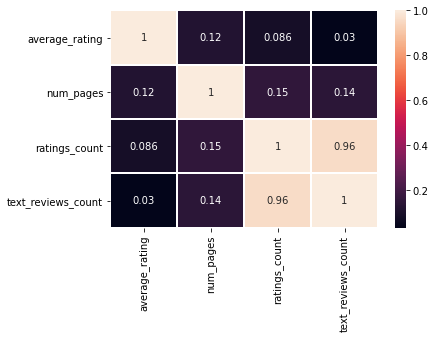

In [55]:
# визуализация корреляции
sns.heatmap (db.corr(method='spearman'), annot=True, linewidths=1)

# Дисперсионный анализ
Корреляция с категориальными признаками  

Проверим три предположения:
- на среднюю оценку влияет наличие/отсутствие соавтора/переводчика,
- на среднюю оценку влияет декада,
- на среднюю оценку влияет квартал.

Проведем тест ANOVA (который также называется дисперсионным анализом). Сначала нужно установить, что выполняются условия для этого теста:
- выборки не зависимые,
- зависимая переменная нормально распределена,
- равенство дисперсий.  

Мы уже знаем, что нормального распределния у нас нет, проверим равенство дисперсий.

In [56]:
# проверка на равенство дисперсий, тест Левена
pg.homoscedasticity (db, dv='average_rating', group='tra_co')

W  pval  equal_var
levene 0.385 0.535       True

Мы принимаем нулевую гипотезу о равенстве дисперсий, так как p-value > 0.05. Но данные не распределены нормально, поэтому параметрический тест применить нельзя.  
Воспользуемся непараметрическими тестами, например, перестановочным тестом. 

Смысл перестановочного теста состоит в следующем. Нам требуется проверить, различаются ли средние между группами в признаке. Мы считаем эту разницу на фактических данных.  
Далее, мы перемешиваем данные по группам, выделяем из этих данных две новые группы, считаем статистику на них. Так мы делаем, например, 10 000 раз. Получаем 10 000 значений статистики.  
Смотрим, сколько раз в этом списке полученных значений встречалось наше первоначальное значение, вычисляем вероятность. Если p-value < 0.05, то это означает, что случайно получить разницу  
средних маловероятно, а значит эта разница носит не случайный характер.

In [57]:
# наличие соавтора/переводчика влияет на среднюю оценку книги?
p_value = permutation_test(db[db['tra_co'] == '0']['average_rating'], db[db['tra_co'] == '1']['average_rating'], method='approximate', num_rounds=10000, seed =0)
p_value

9.999000099990002e-05

Получили p-value < 0.05, поэтому нулевую гипотезу отвергаем о равенстве средних. Принимает альтернативную гипотезу о том, что средние не равны.  
Значит для книг с переводчиком оценка отличается от оценок для книг без переводчиков.  
Это же можно проверить с помощью дисперсионного анализа, у нас выполняются не все условия для классической ANOVA, поэтому применим непараметрический тест Велча.

In [58]:
# проверяем статистику
aov_W = welch_anova( dv='average_rating', between='tra_co', data=db)
aov_W

Source  ddof1    ddof2      F  p-unc   np2
0  tra_co      1 9265.317 91.503  0.000 0.008

Нулевая гипотеза: средние оценки для книг с соавторами/переводчиками и без них равны.  
Мы видим, что p-value равно 0.00, значит, мы должны отвергнуть нулевую гипотезу и принять альтернативную: средние не равны.  
Нет смысла искать между какими группами есть отличия, так как групп всего две.
Переводчик влияет на оценку книги.

In [59]:
# на среднюю оценку влияет декада?
aov_W1 = welch_anova( dv='average_rating', between='decade', data=db)
aov_W1

Source  ddof1  ddof2     F  p-unc   np2
0  decade     12 29.927 2.351  0.029 0.004

Отвергаем нулевую гипотезу о равенстве средних, принимаем альтернативную гипотезу, что средние не равны.  
Средняя оценка зависит от декады, в которой вышла книга.

In [60]:
# на среднюю оценку влияет квартал?
aov_W2 = welch_anova( dv='average_rating', between='quarter', data=db)
aov_W2

Source  ddof1    ddof2     F  p-unc   np2
0  quarter      3 6003.618 4.802  0.002 0.001

Отвергаем нулевую гипотезу о равенстве средних, принимаем альтернативную гипотезу, что средние не равны.  
Средняя оценка зависит от квартала, в котором вышла книга.
Посмотрим, между какими кварталами есть разница.

In [61]:
# ищем, какие группы отличаются
pg.pairwise_gameshowell( data=db, dv='average_rating', between='quarter')

A  B  mean(A)  mean(B)   diff    se      T       df  pval  hedges
0  1  2    3.940    3.926  0.014 0.008  1.722 5263.419 0.313   0.047
1  1  3    3.940    3.945 -0.005 0.008 -0.575 5353.146 0.900  -0.016
2  1  4    3.940    3.957 -0.016 0.008 -1.998 5267.451 0.189  -0.055
3  2  3    3.926    3.945 -0.019 0.008 -2.347 5529.298 0.088  -0.063
4  2  4    3.926    3.957 -0.030 0.008 -3.746 5418.750 0.001  -0.102
5  3  4    3.945    3.957 -0.012 0.008 -1.473 5541.215 0.455  -0.039

Видим, что разница есть между вторым и четвертым кварталом (p-value < 0.05).  

### Выводы
- На среднюю оценку не влияют количественные признаки, в том числе количество страниц в книге.
- На среднюю оценку влияют категориальные признаки: наличие/отсутствие соавтора/переводчика, декада выпуска книги, квартал выпуска книги.  

Далее изучим названия книг, получим для них количественные характеристики посмотрим, как они влияют на оценку книги.

# Анализ названий книг
Проанализируем названия книг, для этого применим NLTK и базовые принципы работы с естественным языком.

В title часто задано не только название книги, но и какая-то характеристика в скобках.

In [62]:
# экранируем скобку, иначе код выдаст ошибку
db[db['title'].str.contains('\(')]

title  \
publication_date                                                      
2006-09-16        Harry Potter and the Half-Blood Prince (Harry ...   
2004-09-01        Harry Potter and the Order of the Phoenix (Har...   
2003-11-01        Harry Potter and the Chamber of Secrets (Harry...   
2004-05-01        Harry Potter and the Prisoner of Azkaban (Harr...   
2004-09-13        Harry Potter Boxed Set  Books 1-5 (Harry Potte...   
...                                                             ...   
2003-08-15        O Cavalo e o Seu Rapaz (As Crónicas de Nárnia ...   
2003-04-08         O Sobrinho do Mágico (As Crónicas de Nárnia  #1)   
2004-09-01        A Viagem do Caminheiro da Alvorada (As Crónica...   
2003-10-11           O Príncipe Caspian (As Crónicas de Nárnia  #4)   
1993-08-01                          The Ice-Shirt (Seven Dreams #1)   

                                                      authors  average_rating  \
publication_date                                                                
2006-09-16                         J.K. Rowling,Mary GrandPré           4.570   
2004-09-01                         J.K. Rowling,Mary GrandPré           4.490   
2003-11-01                                       J.K. Rowling           4.420   
2004-05-01                         J.K. Rowling,Mary GrandPré           4.560   
2004-09-13                         J.K. Rowling,Mary GrandPré           4.780   
...                                                       ...             ...   
2003-08-15        C.S. Lewis,Pauline Baynes,Ana Falcão Bastos           3.920   
2003-04-08        C.S. Lewis,Pauline Baynes,Ana Falcão Bastos           4.040   
2004-09-01        C.S. Lewis,Pauline Baynes,Ana Falcão Bastos           4.090   
2003-10-11        C.S. Lewis,Pauline Baynes,Ana Falcão Bastos           3.970   
1993-08-01                                William T. Vollmann           3.960   

                 language_code  num_pages  ratings_count  text_reviews_count  \
publication_date                                                               
2006-09-16                 eng        652        2095690               27591   
2004-09-01                 eng        870        2153167               29221   
2003-11-01                 eng        352           6333                 244   
2004-05-01                 eng        435        2339585               36325   
2004-09-13                 eng       2690          41428                 164   
...                        ...        ...            ...                 ...   
2003-08-15                 por        160            207                  16   
2003-04-08                 por        147            396                  37   
2004-09-01                 por        176            161                  14   
2003-10-11                 por        160            215                  11   
1993-08-01                 eng        415            820                  95   

                           publisher decade quarter tra_co  
publication_date                                            
2006-09-16           Scholastic Inc.   2000       3      1  
2004-09-01           Scholastic Inc.   2000       3      1  
2003-11-01                Scholastic   2000       4      0  
2004-05-01           Scholastic Inc.   2000       2      1  
2004-09-13                Scholastic   2000       3      1  
...                              ...    ...     ...    ...  
2003-08-15        Editorial Presença   2000       3      1  
2003-04-08        Editorial Presença   2000       2      1  
2004-09-01        Editorial Presença   2000       3      1  
2003-10-11        Editorial Presença   2000       4      1  
1993-08-01             Penguin Books   1990       3      0  

[2640 rows x 11 columns]

Удалим скобки, но работать будем с копией таблицы (так как то, что в скобках, само по себе важный признак).  
Нас интересует просто название книги.

In [64]:
# создаем копию датафрейма
db_copy = db.copy()

In [65]:
# применяем регулярное выражение, чтобы найти скобки и удалить их
db_copy['title'] = db_copy['title'].str.replace(r"\(.*\)","")

<ipython-input-65-d9d2595b3710>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  db_copy['title'] = db_copy['title'].str.replace(r"\(.*\)","")


In [66]:
db_copy.head()

title  \
publication_date                                               
2006-09-16           Harry Potter and the Half-Blood Prince    
2004-09-01        Harry Potter and the Order of the Phoenix    
2003-11-01          Harry Potter and the Chamber of Secrets    
2004-05-01         Harry Potter and the Prisoner of Azkaban    
2004-09-13                Harry Potter Boxed Set  Books 1-5    

                                     authors  average_rating language_code  \
publication_date                                                             
2006-09-16        J.K. Rowling,Mary GrandPré           4.570           eng   
2004-09-01        J.K. Rowling,Mary GrandPré           4.490           eng   
2003-11-01                      J.K. Rowling           4.420           eng   
2004-05-01        J.K. Rowling,Mary GrandPré           4.560           eng   
2004-09-13        J.K. Rowling,Mary GrandPré           4.780           eng   

                  num_pages  ratings_count  text_reviews_count  \
publication_date                                                 
2006-09-16              652        2095690               27591   
2004-09-01              870        2153167               29221   
2003-11-01              352           6333                 244   
2004-05-01              435        2339585               36325   
2004-09-13             2690          41428                 164   

                        publisher decade quarter tra_co  
publication_date                                         
2006-09-16        Scholastic Inc.   2000       3      1  
2004-09-01        Scholastic Inc.   2000       3      1  
2003-11-01             Scholastic   2000       4      0  
2004-05-01        Scholastic Inc.   2000       2      1  
2004-09-13             Scholastic   2000       3      1

In [67]:
# смотрим количество символов в названии книг
db_copy['title'].str.len().sort_values(ascending=False)[:5]

publication_date
2004-09-30    254
2000-05-01    210
2007-04-01    209
2002-12-01    202
2001-07-17    198
Name: title, dtype: int64

In [68]:
# посмотрим книги с длинными названиями
db_copy[db_copy['title'].str.len() > 200]

title  \
publication_date                                                      
2002-12-01        Christian Mythmakers: C.S. Lewis  Madeleine L'...   
2007-04-01        Dr. Mary's Monkey: How the Unsolved Murder of ...   
2004-09-30        Yours in Food  John Baldessari: with meditatio...   
2000-05-01        The covert war against rock: what you don't kn...   

                                                            authors  \
publication_date                                                      
2002-12-01                              Rolland Hein,Clyde S. Kilby   
2007-04-01                               Edward T. Haslam,Jim Marrs   
2004-09-30        John Baldessari,Paul Auster,Francine Prose,Pet...   
2000-05-01                                         Alex Constantine   

                  average_rating language_code  num_pages  ratings_count  \
publication_date                                                           
2002-12-01                 3.930           eng        303            448   
2007-04-01                 3.920           eng        374           1023   
2004-09-30                 4.000         en-US        144             19   
2000-05-01                 3.580           eng        280             85   

                  text_reviews_count                      publisher decade  \
publication_date                                                             
2002-12-01                        18      Cornerstone Press Chicago   2000   
2007-04-01                       164                      Trine Day   2000   
2004-09-30                         4  Princeton Architectural Press   2000   
2000-05-01                         8                    Feral House   2000   

                 quarter tra_co  
publication_date                 
2002-12-01             4      1  
2007-04-01             2      1  
2004-09-30             3      1  
2000-05-01             2      0

In [69]:
# создадим признак по длине названия
db_copy['len_title'] = db_copy['title'].str.len()

In [70]:
db_copy

title  \
publication_date                                                     
2006-09-16                 Harry Potter and the Half-Blood Prince    
2004-09-01              Harry Potter and the Order of the Phoenix    
2003-11-01                Harry Potter and the Chamber of Secrets    
2004-05-01               Harry Potter and the Prisoner of Azkaban    
2004-09-13                      Harry Potter Boxed Set  Books 1-5    
...                                                            ...   
2004-12-21        Expelled from Eden: A William T. Vollmann Reader   
1988-12-01                             You Bright and Risen Angels   
1993-08-01                                          The Ice-Shirt    
2007-02-27                                             Poor People   
2006-05-28                             Las aventuras de Tom Sawyer   

                                                            authors  \
publication_date                                                      
2006-09-16                               J.K. Rowling,Mary GrandPré   
2004-09-01                               J.K. Rowling,Mary GrandPré   
2003-11-01                                             J.K. Rowling   
2004-05-01                               J.K. Rowling,Mary GrandPré   
2004-09-13                               J.K. Rowling,Mary GrandPré   
...                                                             ...   
2004-12-21        William T. Vollmann,Larry McCaffery,Michael He...   
1988-12-01                                      William T. Vollmann   
1993-08-01                                      William T. Vollmann   
2007-02-27                                      William T. Vollmann   
2006-05-28                                               Mark Twain   

                  average_rating language_code  num_pages  ratings_count  \
publication_date                                                           
2006-09-16                 4.570           eng        652        2095690   
2004-09-01                 4.490           eng        870        2153167   
2003-11-01                 4.420           eng        352           6333   
2004-05-01                 4.560           eng        435        2339585   
2004-09-13                 4.780           eng       2690          41428   
...                          ...           ...        ...            ...   
2004-12-21                 4.060           eng        512            156   
1988-12-01                 4.080           eng        635            783   
1993-08-01                 3.960           eng        415            820   
2007-02-27                 3.720           eng        434            769   
2006-05-28                 3.910           spa        272            113   

                  text_reviews_count        publisher decade quarter tra_co  \
publication_date                                                              
2006-09-16                     27591  Scholastic Inc.   2000       3      1   
2004-09-01                     29221  Scholastic Inc.   2000       3      1   
2003-11-01                       244       Scholastic   2000       4      0   
2004-05-01                     36325  Scholastic Inc.   2000       2      1   
2004-09-13                       164       Scholastic   2000       3      1   
...                              ...              ...    ...     ...    ...   
2004-12-21                        20    Da Capo Press   2000       4      1   
1988-12-01                        56    Penguin Books   1980       4      0   
1993-08-01                        95    Penguin Books   1990       3      0   
2007-02-27                       139             Ecco   2000       1      0   
2006-05-28                        12    Edimat Libros   2000       2      0   

                  len_title  
publication_date             
2006-09-16               39  
2004-09-01               42  
2003-11-01               40  
2004-05-01               41  
2004-09-13               34  

In [71]:
# объединим все названия в один список
title_list = list(db_copy['title'])

In [72]:
# проверяем длину списка
len(title_list)

10838

In [73]:
# объединим в один текст
text = ' '.join(title_list)

In [74]:
# делим на слова
words = re.findall('\w+', text)
# количество слов
len(words)

56639

In [75]:
# количество уникальных слов
len(set(words)) # set - множество, может содержать только уникальные значения

10802

In [76]:
(len(set(words)) / len(words)) * 100

19.071664400854534

Уникальные слова составляют только 19% от всех слов в названиях книг. Можно полагать, что названия книг достаточно разнообразны.  
Посмотрим, насколько длинные слова используют в названиях книг.

In [77]:
x = [len(w) for w in words]

In [78]:
fdist = nltk.FreqDist(x)

In [79]:
fdist.tabulate()

    3     5     4     2     6     7     8     1     9    10    11    12    13    14    15    17    16    18 
11606  7567  7542  6669  5947  5078  3448  3335  2468  1480   665   429   300    68    18    10     8     1 


Мы видим, что слова в основном короткие - три знака.  
Проведем еще раз деление на слова (токенизацию), но уже другим способом.

In [80]:
# токенизация с помощью NLTK
tokenizer = RegexpTokenizer('\w+')
tokens = tokenizer.tokenize(text)

In [81]:
tokens[:10]

['Harry',
 'Potter',
 'and',
 'the',
 'Half',
 'Blood',
 'Prince',
 'Harry',
 'Potter',
 'and']

In [82]:
words = []
for word in tokens:
    words.append(word.lower()) # убираем заглавные буквы (но при этом теряется часть информации, например, об имени)

In [83]:
words[:10]

['harry',
 'potter',
 'and',
 'the',
 'half',
 'blood',
 'prince',
 'harry',
 'potter',
 'and']

In [86]:
# загружаем стоп-слова
# nltk.download('stopwords')
sw = nltk.corpus.stopwords.words('english')

In [87]:
# добавляем значения в список стоп-слов
sw.extend(['vol', '1', '2'])

In [88]:
words_ns = []

for word in words:
    if word not in sw:
        words_ns.append(word)

In [89]:
words_ns[:10]

['harry',
 'potter',
 'half',
 'blood',
 'prince',
 'harry',
 'potter',
 'order',
 'phoenix',
 'harry']

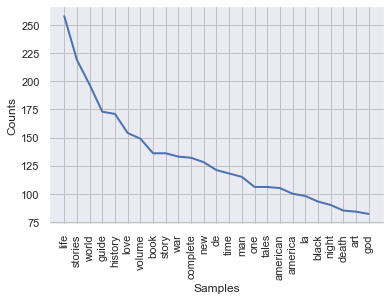

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [90]:
# задаем стиль графика
sns.set()
freq = nltk.FreqDist(words_ns)
freq.plot(25)

Проведем те же операции, но на датафрейме, чтобы получить дополнительные признаки.  
Посмотрим, как применяется лямбда функция, в том числе совместно с генератором.

In [91]:
db_copy['title'] = db_copy['title'].apply(lambda x: tokenizer.tokenize(x)) # разобьем на слова
db_copy['title'] = db_copy['title'].apply(lambda x: " ".join(x for x in x if x not in sw)) # удалим стоп-слова
db_copy['title'] = db_copy['title'].str.lower()


In [92]:
db_copy.head()

title                     authors  \
publication_date                                                               
2006-09-16        harry potter half blood prince  J.K. Rowling,Mary GrandPré   
2004-09-01            harry potter order phoenix  J.K. Rowling,Mary GrandPré   
2003-11-01          harry potter chamber secrets                J.K. Rowling   
2004-05-01         harry potter prisoner azkaban  J.K. Rowling,Mary GrandPré   
2004-09-13        harry potter boxed set books 5  J.K. Rowling,Mary GrandPré   

                  average_rating language_code  num_pages  ratings_count  \
publication_date                                                           
2006-09-16                 4.570           eng        652        2095690   
2004-09-01                 4.490           eng        870        2153167   
2003-11-01                 4.420           eng        352           6333   
2004-05-01                 4.560           eng        435        2339585   
2004-09-13                 4.780           eng       2690          41428   

                  text_reviews_count        publisher decade quarter tra_co  \
publication_date                                                              
2006-09-16                     27591  Scholastic Inc.   2000       3      1   
2004-09-01                     29221  Scholastic Inc.   2000       3      1   
2003-11-01                       244       Scholastic   2000       4      0   
2004-05-01                     36325  Scholastic Inc.   2000       2      1   
2004-09-13                       164       Scholastic   2000       3      1   

                  len_title  
publication_date             
2006-09-16               39  
2004-09-01               42  
2003-11-01               40  
2004-05-01               41  
2004-09-13               34

In [93]:
# функция для оценки эмоций
def senti(data):
    return TextBlob(data).sentiment

In [94]:
# эмоциональность названия книги
db_copy['polarity'] = db_copy['title'].apply(lambda x: TextBlob(x).sentiment.polarity)

# субъективность названия книги
db_copy['subjectivity'] = db_copy['title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [95]:
db_copy.head(20)

title  \
publication_date                                                      
2006-09-16                           harry potter half blood prince   
2004-09-01                               harry potter order phoenix   
2003-11-01                             harry potter chamber secrets   
2004-05-01                            harry potter prisoner azkaban   
2004-09-13                           harry potter boxed set books 5   
2005-04-26        unauthorized harry potter book seven news half...   
2005-09-12                                  harry potter collection   
2005-11-01        the ultimate hitchhiker guide five complete no...   
2002-04-30                     the ultimate hitchhiker guide galaxy   
2004-08-03                              the hitchhiker guide galaxy   
1996-01-17                            the ultimate hitchhiker guide   
2004-09-14                        a short history nearly everything   
2002-12-03                                bill bryson african diary   
2004-09-14        bryson dictionary troublesome words a writer g...   
2001-05-15                                     in sunburned country   
2000-06-28        i stranger here myself notes returning america...   
1990-08-28            the lost continent travels small town america   
1993-03-28                        neither here there travels europe   
1997-05-28                                       notes small island   
1991-09-28            the mother tongue english how it got that way   

                                     authors  average_rating language_code  \
publication_date                                                             
2006-09-16        J.K. Rowling,Mary GrandPré           4.570           eng   
2004-09-01        J.K. Rowling,Mary GrandPré           4.490           eng   
2003-11-01                      J.K. Rowling           4.420           eng   
2004-05-01        J.K. Rowling,Mary GrandPré           4.560           eng   
2004-09-13        J.K. Rowling,Mary GrandPré           4.780           eng   
2005-04-26            W. Frederick Zimmerman           3.740         en-US   
2005-09-12                      J.K. Rowling           4.730           eng   
2005-11-01                     Douglas Adams           4.380           eng   
2002-04-30                     Douglas Adams           4.380           eng   
2004-08-03                     Douglas Adams           4.220           eng   
1996-01-17                     Douglas Adams           4.380           eng   
2004-09-14                       Bill Bryson           4.210           eng   
2002-12-03                       Bill Bryson           3.440           eng   
2004-09-14                       Bill Bryson           3.870           eng   
2001-05-15                       Bill Bryson           4.070           eng   
2000-06-28                       Bill Bryson           3.900           eng   
1990-08-28                       Bill Bryson           3.830           eng   
1993-03-28                       Bill Bryson           3.860           eng   
1997-05-28                       Bill Bryson           3.910           eng   
1991-09-28                       Bill Bryson           3.930           eng   

                  num_pages  ratings_count  text_reviews_count  \
publication_date                                                 
2006-09-16              652        2095690               27591   
2004-09-01              870        2153167               29221   
2003-11-01              352           6333                 244   
2004-05-01              435        2339585               36325   
2004-09-13             2690          41428                 164   
2005-04-26              152             19                   1   
2005-09-12             3342          28242                 808   
2005-11-01              815           3628                 254   
2002-04-30              815         249558                4080   
2004-08-03              215           4930              

Две оценки (-0.5, 0.875) означают: первая негативный/позитивный заголовок (от -1 до 1, от негативного к позитивному, 0 - нейтральный).  
Вторая объективный/субъективный (от 0 до 1, ближе к 1 субъективный).  

Мы получили три новых признака: длина названия, эмоциональная окраска, субъективность. Применим статистический анализ.  
У нас только количественные признаки, установим корреляцию. В average_rating нет нормального распределения, поэтому примени корреляцию Спирмена.

In [96]:
# корреляция один против всех по Спирмену
pg.pairwise_corr(db_copy, columns=[['average_rating'],['len_title', 'polarity', 'subjectivity']], method='spearman', padjust='bonf')

X             Y    method       tail      n     r  \
0  average_rating     len_title  spearman  two-sided  10838 0.163   
1  average_rating      polarity  spearman  two-sided  10838 0.034   
2  average_rating  subjectivity  spearman  two-sided  10838 0.035   

          CI95%    r2  adj_r2     z  p-unc  p-corr p-adjust  power  
0  [0.14, 0.18] 0.026   0.026 0.164  0.000   0.000     bonf  1.000  
1  [0.01, 0.05] 0.001   0.001 0.034  0.000   0.001     bonf  0.938  
2  [0.02, 0.05] 0.001   0.001 0.035  0.000   0.001     bonf  0.953

Видим, что нет слабой корреляции ни с одним признаком.  
Создадим облако слов для книг с положительными и отрицательными оценками.

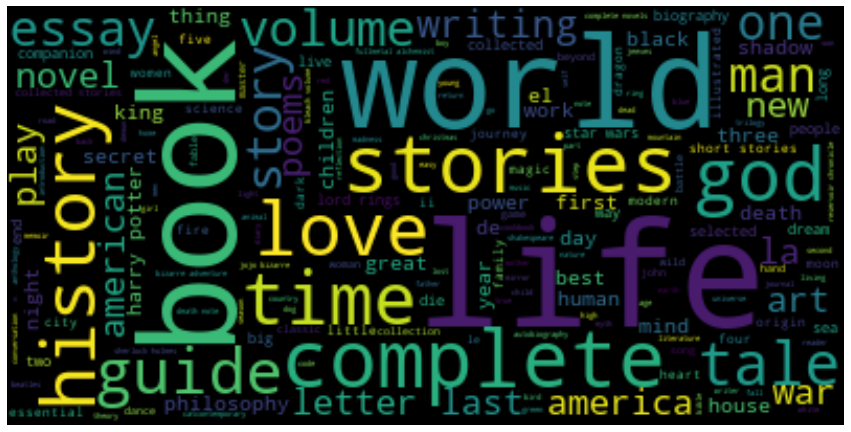

In [97]:
# визуализируем частоту слов, которые встречаются в книгах с положительными и отрицательными оценками
db_copy['rating'] = db_copy['average_rating'].apply(lambda rating: 'positive' if rating > 4 else 'negative')
positive = db_copy[db_copy['rating'] == 'positive']
negative = db_copy[db_copy['rating'] == 'negative']

pos = " ".join(x for x in positive['title'])
# облако с позитивными оценками
wordcloud1 = WordCloud(stopwords=sw).generate(pos)
fig, ax = plt.subplots(figsize=(15,10))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.savefig('data/wordcloud1.png')
plt.show()

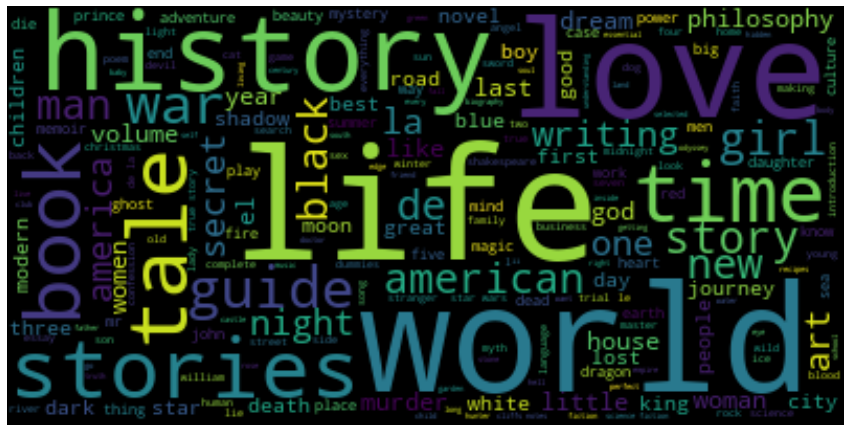

In [99]:
neg = " ".join(x for x in negative['title'])
# облако с негативными оценками
wordcloud2 = WordCloud(stopwords=sw).generate(neg)
fig, ax = plt.subplots(figsize=(15,10))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.savefig('data/wordcloud2.png')
plt.show()